<h1 ><big><center>Object recognition and computer vision 2018/2019</center></big></h1>

<h3><big><center><a href="http://www.di.ens.fr/~ponce/">Jean Ponce</a>, <a href="http://www.di.ens.fr/~laptev/">Ivan Laptev</a>, <a href="http://lear.inrialpes.fr/~schmid/">Cordelia Schmid</a> and <a href="http://www.di.ens.fr/~josef/">Josef Sivic</a></center></big></h3>


<h2><big><center> Assignment 2: Neural networks</center></big></h2>

<h5><big><center>Adapted from practicals from <a href="http://nicolas.le-roux.name/">Nicolas le Roux</a>, 
  <br><a href="http://www.robots.ox.ac.uk/~vgg/practicals/overview/index.html">Andrea Vedaldi and Andrew Zisserman</a> and <a href="https://cs.nyu.edu/~fergus/teaching/vision/">Rob Fergus</a>
  <br> by <a href="https://www.di.ens.fr/~varol/">Gul Varol</a> and <a href="https://www.di.ens.fr/~iroccosp/">Ignacio Rocco</a></center></big></h5>


</br>

<p align="center">
<img height=300px src="http://www.di.ens.fr/willow/teaching/recvis/assignment3/images/fullyconn.png"/></p>
<p align="center">Figure 1</p>
<p align="center"></p>

**STUDENT**:  Amine SADEQ

**EMAIL**:  amine.sadeq@student.ecp.fr

# Guidelines

The purpose of this assignment is that you get hands-on experience with the topics covered in class, which will help you understand these topics better. Therefore, ** it is imperative that you do this assignment yourself. No code sharing will be tolerated. **

Once you have completed the assignment, you will submit the `ipynb` file containing **both** code and results. For this, make sure to **run your notebook completely before submitting**.

The `ipynb` must be named using the following format: **A2_LASTNAME_Firstname.ipynb**, and submitted in the **class Moodle page**.

# Goal


The goal of this assignment is to get basic knowledge and hands-on experience with training and using neural networks. In Part 1 of the assignment you will implement and experiment with the training and testing of a simple two layer fully-connected neural network, similar to the one depicted in Figure 1 above. In Part 2 you will learn about convolutional neural networks, their motivation, building blocks, and how they are trained. Finally, in part 3 you will train a CNN for classification using the CIFAR-10 dataset.

# Part 1 - Training a fully connected neural network

## Getting started

You will be working with a two layer neural network of the following form 

\begin{equation}
H=\text{ReLU}(W_i X+B_i)\\
Y=W_oH+B_o
\tag{1}
\end{equation}

where $X$ is the input, $Y$ is the output, $H$ is the hidden layer, and $W_i$, $W_o$, $B_i$ and $B_o$ are the network parameters that need to be trained. Here the subscripts $i$ and $o$ stand for the *input* and *output* layer, respectively. This network was also discussed in the class and is illustrated in the above figure where the input units are shown in green, the hidden units in blue and the output in yellow. This network is implemented in the function `nnet_forward_logloss`.

You will train the parameters of the network from labelled training data $\{X^n,Y^n\}$ where $X^n$ are points in $\mathbb{R}^2$ and $Y^n\in\{-1,1\}$ are labels for each point. You will use the stochastic gradient descent algorithm discussed in the class to minimize the loss of the network on the training data given by 

\begin{equation}
L=\sum_n s(Y^n,\bar{Y}(X^n))
\tag{2}
\end{equation}

where $Y^n$ is the target label for the n-th example and $\bar{Y}(X^n)$ is the network’s output for the n-th example $X^n$. The skeleton of the training procedure is provided in the `train_loop` function. 

We will use the logistic loss, which has the following form:

\begin{equation}
s(Y, \bar{Y}(X))=\log(1+\exp(-Y. \bar{Y}(X))
\tag{3}
\end{equation}

where $Y$ is the target label and $\bar{Y}(X)$ is the output of the network for input example $X$. With the logistic loss, the output of the network can be interpreted as a probability $P(\text{class}=1|X) =\sigma(X)$ , where $\sigma(X) =1/(1+\exp(-X))$ is the sigmoid function. Note also that $P(\text{class}=-1|X)=1-P(\text{class}=1|X)$.

In [3]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
#%matplotlib notebook


def decision_boundary_nnet(X, Y, Wi, bi, Wo, bo):
    x_min, x_max = -2, 4
    y_min, y_max = -5, 3
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .05),
                     np.arange(y_min, y_max, .05))

    XX = np.vstack((xx.ravel(), yy.ravel())).T
    input_hidden = np.dot(XX, Wi) + bi
    hidden = np.maximum(input_hidden, 0)
    Z = np.dot(hidden, Wo) + bo

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z > 0, cmap=plt.cm.Paired)
    plt.axis('off')

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='winter')
    plt.axis([-2, 4, -5, 3])
    plt.draw()


def sigm(x):
    # Returns the sigmoid of x.
    small_x = np.where(x < -20)  # Avoid overflows.
    sigm_x = 1/(1 + np.exp(-x))
    if type(sigm_x) is np.ndarray:
        sigm_x[small_x] = 0.0
    return sigm_x


def nnet_forward_logloss(X, Y, Wi, bi, Wo, bo):
    '''
    Compute the output Po, Yo and the loss of the network for the input X
    This is a 2 layer (1 hidden layer network)

    Input:
        X ... (in R^2) set of input points, one per column
        Y ... {-1,1} the target values for the set of points X
        Wi, bi, Wo, bo ... parameters of the network

    Output: 
       Po ... probabilisitc output of the network P(class=1 | x) 
                  Po is in <0 1>. 
                  Note: P(class=-1 | x ) = 1 - Po
       Yo ... output of the network Yo is in <-inf +inf>
       loss ... logistic loss of the network on examples X with ground target
                    values Y in {-1,1}
    '''
    # Hidden layer
    hidden = np.maximum(np.dot(X, Wi) + bi, 0)
    # Output of the network
    Yo = np.dot(hidden, Wo) + bo
    # Probabilistic output
    Po = sigm(Yo)
    # Logistic loss
    loss = np.log(1 + np.exp( -Y * Yo)) 
    return Po, Yo, loss


# Load the training data
!wget -q http://www.di.ens.fr/willow/teaching/recvis18/assignment2/double_moon_train1000.mat
train_data = sio.loadmat('./double_moon_train1000.mat', squeeze_me=True)
Xtr = train_data['X']
Ytr = train_data['Y']
# Load the validation data
!wget -q http://www.di.ens.fr/willow/teaching/recvis18/assignment2/double_moon_val1000.mat
val_data = sio.loadmat('./double_moon_val1000.mat', squeeze_me=True)
Xval = val_data['X']
Yval = val_data['Y']

## Computing gradients of the loss with respect to network parameters 

### :: TASK 1.1 ::
Derive the form of the gradient of the logistic loss (3) with respect to the parameters of the network $W_i$, $W_o$, $B_i$ and $B_o$.  *Hint:* Use the chain rule as discussed in the class.


$$ 
\begin{align*} 
    Z_1 &= W_i^TX+b_i \\
    \frac{\partial L}{\partial W_o} &=  \frac{\partial L}{\partial \bar Y}\frac{\partial \bar Y}{\partial W_o} = -Y\sigma(-Y \bar Y) H \\
    \frac{\partial L}{\partial b_o} &=  \frac{\partial L}{\partial \bar Y}\frac{\partial \bar Y}{\partial b_o} = -Y\sigma(-Y \bar Y) \\
    \frac{\partial L}{\partial W_i} &=  \frac{\partial L}{\partial \bar Y}\frac{\partial \bar Y}{\partial H}\frac{\partial H}{\partial Z_1}\frac{\partial Z_1}{\partial W_i}  = - Y\sigma(-Y \bar Y)  X  (W_o \bullet \mathbb{1}_{x>0}(Z_1))^T  \\
    \frac{\partial L}{\partial b_i} &=  \frac{\partial L}{\partial \bar Y}\frac{\partial \bar Y}{\partial H}\frac{\partial H}{\partial Z_1}\frac{\partial Z_1}{\partial b_i} = -Y\sigma(-Y \bar Y) W_o \mathbb{1}_{x>0}(Z_1)
\end{align*}
$$



### :: TASK 1.2 ::

Following your derivation, implement the gradient computation in the function `gradient_nn`. See the code for the description of the required inputs / outputs of this function.

In [13]:
def gradient_nn(X, Y, Wi, bi, Wo, bo):
    '''
    Compute gradient of the logistic loss of the neural network on example X with
    target label Y, with respect to the parameters Wi,bi,Wo,bo.

    Input:
        X ... 2d vector of the input example
        Y ... the target label in {-1,1}   
        Wi,bi,Wo,bo ... parameters of the network
        Wi ... [dxh]
        bi ... [h]
        Wo ... [h]
        bo ... 1
        where h... is the number of hidden units
              d... is the number of input dimensions (d=2)

    Output: 
        grad_s_Wi [dxh] ... gradient of loss s(Y,Y(X)) w.r.t  Wi
        grad_s_bi [h]   ... gradient of loss s(Y,Y(X)) w.r.t. bi
        grad_s_Wo [h]   ... gradient of loss s(Y,Y(X)) w.r.t. Wo
        grad_s_bo 1     ... gradient of loss s(Y,Y(X)) w.r.t. bo
    '''

    ##########################
    #                        #
    #  WRITE YOUR CODE HERE  #
    #                        #
    ##########################
    H = np.maximum(0,np.dot(Wi.T,X)+bi)
    Y_hat = np.sum(Wo*H)+bo
    grad_s_Wi = np.dot(X.reshape(-1,1),(-Y*sigm(-Y*Y_hat)*Wo*np.maximum(0,np.sign(np.dot(Wi.T,X)+bi))).reshape(1,-1))
    grad_s_bi = -Y*sigm(-Y*Y_hat)*Wo*np.maximum(0,np.sign(np.dot(Wi.T,X)+bi))
    grad_s_Wo = -Y*sigm(-Y*Y_hat)*H
    grad_s_bo = -Y*sigm(-Y*Y_hat)
    ##########################
    return grad_s_Wi,grad_s_bi,grad_s_Wo,grad_s_bo

## Numerically verify the gradients
Here you will numerically verify that your analytically computed gradients in function `gradient_nn` are correct. 

### :: TASK 1.3 ::
Write down the general formula for numerically computing the approximate derivative of the loss $s(\theta)$, with respect to the parameter $\theta_i$ using finite differencing.  *Hint: use the first order Taylor expansion of loss $s(\theta+\Delta \theta)$ around point $\theta$. *

######################

$$
\begin{align*}
\frac{\partial s}{\partial \theta} &= \frac{s(\theta+\Delta\theta)-s(\theta)}{\Delta\theta} \\ 
\frac{\partial s}{\partial \theta} &= \frac{s(\theta+\Delta\theta) - s(\theta-\Delta\theta)}{2\Delta\theta}
\end{align*}
$$
######################

Following the general formula, `gradient_nn_numerical` function numerically computes the derivatives of the loss function with respect to all the parameters of the network $W_i$, $W_o$, $B_i$ and $B_o$:

In [14]:
def gradient_nn_numerical(X, Y, Wi, bi, Wo, bo):
    '''
    Compute numerical gradient of the logistic loss of the neural network on
    example X with target label Y, with respect to the parameters Wi,bi,Wo,bo.

    Input:
       X ... 2d vector of the input example
       Y ... the target label in {-1,1}   
       Wi, bi, Wo, bo ... parameters of the network
       Wi ... [dxh]
       bi ... [h]
       Wo ... [h]
       bo ... 1
       where h... is the number of hidden units
             d... is the number of input dimensions (d=2)

    Output: 
       grad_s_Wi_numerical [dxh] ... gradient of loss s(Y,Y(X)) w.r.t  Wi
       grad_s_bi_numerical [h]   ... gradient of loss s(Y,Y(X)) w.r.t. bi
       grad_s_Wo_numerical [h]   ... gradient of loss s(Y,Y(X)) w.r.t. Wo
       grad_s_bo_numerical 1     ... gradient of loss s(Y,Y(X)) w.r.t. bo
    '''

    eps = 1e-8
    grad_s_Wi_numerical = np.zeros(Wi.shape)
    grad_s_bi_numerical = np.zeros(bi.shape)
    grad_s_Wo_numerical = np.zeros(Wo.shape)

    for i in range(Wi.shape[0]):
        for j in range(Wi.shape[1]):
            dummy, dummy, pos_loss = nnet_forward_logloss(X, Y, sumelement_matrix(Wi, i, j, +eps), bi, Wo, bo)
            dummy, dummy, neg_loss = nnet_forward_logloss(X, Y, sumelement_matrix(Wi, i, j, -eps), bi, Wo, bo)
            grad_s_Wi_numerical[i, j] = (pos_loss - neg_loss)/(2*eps)

    for i in range(bi.shape[0]):
        dummy, dummy, pos_loss = nnet_forward_logloss(X, Y, Wi, sumelement_vector(bi, i, +eps), Wo, bo)
        dummy, dummy, neg_loss = nnet_forward_logloss(X, Y, Wi, sumelement_vector(bi, i, -eps), Wo, bo)
        grad_s_bi_numerical[i] = (pos_loss - neg_loss)/(2*eps)

    for i in range(Wo.shape[0]):
        dummy, dummy, pos_loss = nnet_forward_logloss(X, Y, Wi, bi, sumelement_vector(Wo, i, +eps), bo)
        dummy, dummy, neg_loss = nnet_forward_logloss(X, Y, Wi, bi, sumelement_vector(Wo, i, -eps), bo)
        grad_s_Wo_numerical[i] = (pos_loss - neg_loss)/(2*eps)

    dummy, dummy, pos_loss = nnet_forward_logloss(X, Y, Wi, bi, Wo, bo+eps)
    dummy, dummy, neg_loss = nnet_forward_logloss(X, Y, Wi, bi, Wo, bo-eps)
    grad_s_bo_numerical = (pos_loss - neg_loss)/(2*eps)

    return grad_s_Wi_numerical, grad_s_bi_numerical, grad_s_Wo_numerical, grad_s_bo_numerical


def sumelement_matrix(X, i, j, element):
    Y = np.copy(X)
    Y[i, j] = X[i, j] + element
    return Y


def sumelement_vector(X, i, element):
    Y = np.copy(X)
    Y[i] = X[i] + element
    return Y

### :: TASK 1.4 ::

Run the following code snippet and understand what it is doing. `gradcheck` function checks that the analytically computed derivative using function `gradient_nn` (e.g. `grad_s_bo`) at the same training example $\{X,Y\}$ is the same (up to small errors) as your numerically computed value of the derivative using function `gradient_nn_numerical` (e.g. `grad_s_bo_numerical`). Make sure the output is `SUCCESS` to move on to the next task.

In [16]:
def gradcheck():
    '''
    Check that the numerical and analytical gradients are the same up to eps
    '''
    h = 3 # number of hidden units
    eps = 1e-6
    for i in range(1000):
        # Generate random input/output/weight/bias
        X  = np.random.randn(2)
        Y  = 2* np.random.randint(2) - 1 # {-1, 1}
        Wi = np.random.randn(X.shape[0], h)
        bi = np.random.randn(h)
        Wo = np.random.randn(h)
        bo = np.random.randn(1)
        # Compute analytical gradients
        grad_s_Wi, grad_s_bi, grad_s_Wo, grad_s_bo = gradient_nn(X, Y, Wi, bi, Wo, bo)
        # Compute numerical gradients
        grad_s_Wi_numerical, grad_s_bi_numerical, grad_s_Wo_numerical, grad_s_bo_numerical = gradient_nn_numerical(X, Y, Wi, bi, Wo, bo)
        # Compute the difference between analytical and numerical gradients
        delta_Wi = np.mean(np.abs(grad_s_Wi - grad_s_Wi_numerical))
        delta_bi = np.mean(np.abs(grad_s_bi - grad_s_bi_numerical))
        delta_Wo = np.mean(np.abs(grad_s_Wo - grad_s_Wo_numerical))
        delta_bo = np.abs(grad_s_bo - grad_s_bo_numerical)
        # Difference larger than a threshold
        if ( delta_Wi > eps or delta_bi > eps or delta_Wo > eps or delta_bo > eps):
            return False
    
    return True 


# Check gradients
if gradcheck():
    print('SUCCESS: Passed gradcheck.')
else:
    print('FAILURE: Fix gradient_nn and/or gradient_nn_aprox implementation.')
    

SUCCESS: Passed gradcheck.


## Training the network using backpropagation and experimenting with different parameters

Use the provided code below that calls the `train_loop` function. Set the number of hidden units to 7 by setting $h=7$ in the code and set the learning rate to 0.02 by setting `lrate = 0.02`. Run the training code. Visualize the trained hyperplane using the provided function `plot_decision_boundary(Xtr,Ytr,Wi,bi,Wo,bo)`. Show also the evolution of the training and validation errors. Include the decision hyper-plane visualization and the training and validation error plots.

In [17]:
def train_loop(Xtr, Ytr, Xval, Yval, h, lrate, vis='all', nEpochs=100):
    '''
    Check that the numerical and analytical gradients are the same up to eps

    Input:
        Xtr ... Nx2 matrix of training samples
        Ytr ... N dimensional vector of training labels
        Xval ... Nx2 matrix of validation samples 
        Yval ... N dimensional vector validation labels
        h ... number of hidden units
        lrate ... learning rate
        vis ... visulaization option ('all' | 'last' | 'never')
        nEpochs ... number of training epochs

    Output:
        tr_error ... nEpochs*nSamples dimensional vector of training error
        val_error ... nEpochs*nSamples dimensional vector of validation error
    '''

    nSamples = Xtr.shape[0]
    tr_error = np.zeros(nEpochs*nSamples)
    val_error = np.zeros(nEpochs*nSamples)

    # Randomly initialize parameters of the model
    Wi = np.random.randn(Xtr.shape[1], h)
    Wo = np.zeros(h)
    bi = np.zeros(h)
    bo = 0.

    if(vis == 'all' or vis == 'last'):
        plt.figure()

    for i in range(nEpochs*nSamples):
        # Draw an example at random
        n = np.random.randint(nSamples)
        X = Xtr[n]
        Y = Ytr[n]

        # Compute gradient 
        grad_s_Wi, grad_s_bi, grad_s_Wo, grad_s_bo = gradient_nn(X, Y, Wi, bi, Wo, bo)

        # Gradient update
        Wi -= lrate*grad_s_Wi
        Wo -= lrate*grad_s_Wo
        bi -= lrate*grad_s_bi
        bo -= lrate*grad_s_bo

        # Compute training error
        Po, Yo, loss    = nnet_forward_logloss(Xtr, Ytr, Wi, bi, Wo, bo)
        Yo_class        = np.sign(Yo)
        tr_error[i]     = 100*np.mean(Yo_class != Ytr)

        # Compute validation error
        Pov, Yov, lossv = nnet_forward_logloss(Xval, Yval, Wi, bi, Wo, bo)
        Yov_class       = np.sign(Yov)
        val_error[i]    = 100*np.mean(Yov_class != Yval)

        # Plot (at every epoch if visualization is 'all', only at the end if 'last')
        if(vis == 'all' and i%nSamples == 0) or (vis == 'last' and i == nEpochs*nSamples - 1):
            # Draw the decision boundary.
            plt.clf()
            plt.title('p = %d, Iteration = %.d, Error = %.3f' % (h, i/nSamples, tr_error[i]))
            decision_boundary_nnet(Xtr, Ytr, Wi, bi, Wo, bo)
            display.display(plt.gcf(), display_id=True)
            display.clear_output(wait=True)

    if(vis == 'all'):
        # Plot the evolution of the training and test errors
        plt.figure()
        plt.plot(tr_error, label='training')
        plt.plot(val_error, label='validation')
        plt.legend()
        plt.title('Training/validation errors: %.2f%% / %.2f%%' % (tr_error[-1], val_error[-1]))
    return tr_error, val_error

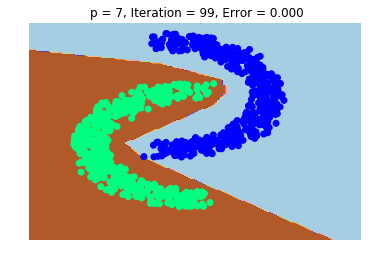

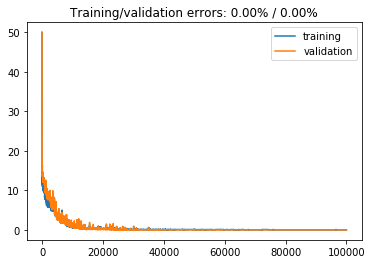

In [22]:
# Run training
h = 7
lrate = .02
tr_error, val_error = train_loop(Xtr, Ytr, Xval, Yval, h, lrate)

### :: TASK 1.6 ::

**Random initializations.** Repeat this procedure 5 times from 5 different random initializations. Record for each run the final training and validation errors. Did the network always converge to zero training error? Summarize your final training and validation errors into a table for the 5 runs. You do not need to include the decision hyper-plane visualizations. Note: to speed-up the training you can plot the visualization figures less often (or never) and hence speed-up the training.

In [21]:
##########################
#                        #
#  WRITE YOUR CODE HERE  #
#                        #
##########################
result = []
for i in range(5) : 
    tr_error, val_error = train_loop(Xtr, Ytr, Xval, Yval, h, lrate,vis='never')
    result.append([tr_error[-1],val_error[-1]])
result

[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]

|  Iterations |  Train error  | Validation error   |
|:---:|:---:|:---:|
|  1 |  0  | 0   |
|  2 |  0  | 0   |
|  3 |  0  | 0   |
|  4 |  0  | 0   |
|  5 |  0  | 0   |


### :: SAMPLE TASK ::

For this task, the answer is given. Run the given code and answer Task 1.8 similarly.

**Learning rate:**

Keep $h=7$ and change the learning rate to values $\text{lrate} = \{2, 0.2, 0.02, 0.002\}$. For each of these values run the training procedure 5 times and observe the training behaviour. You do not need to include the decision hyper-plane visualizations in your answer.

**- Make one figure** where *final* error for (i) training and (ii) validation sets are superimposed. $x$-axis should be the different values of the learning rate, $y$-axis the error *mean* across 5 runs. Show the standard deviation with error bars and make sure to label each plot with a legend.

**- Make another figure** where *training error evolution* for each learning rate is superimposed. $x$-axis should be the iteration number, $y$-axis the training error *mean* across 5 runs for a given learning rate. Show the standard deviation with error bars and make sure to label each curve with a legend.

In [141]:
nEpochs = 40
trials = 5
lrates = [2, 0.2, 0.02, 0.002]
plot_data_lr = np.zeros((2, trials, len(lrates), nEpochs*1000))
h = 7
for j, lrate in enumerate(lrates):
    print('LR = %f' % lrate)
    for i in range(trials):
        tr_error, val_error = train_loop(Xtr, Ytr, Xval, Yval, h, lrate, vis='never', nEpochs=nEpochs)
        plot_data_lr[0, i, j, :] = tr_error
        plot_data_lr[1, i, j, :] = val_error

LR = 2.000000
LR = 0.200000
LR = 0.020000
LR = 0.002000


Text(0, 0.5, 'training error')

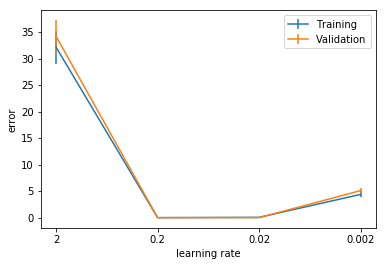

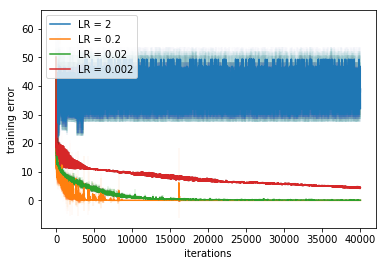

In [142]:
plt.errorbar(np.arange(len(lrates)), plot_data_lr[0, :, :, -1].mean(axis=0), yerr=plot_data_lr[0, :, :, -1].std(axis=0), label='Training')
plt.errorbar(np.arange(len(lrates)), plot_data_lr[1, :, :, -1].mean(axis=0), yerr=plot_data_lr[0, :, :, -1].std(axis=0), label='Validation')
plt.xticks(np.arange(len(lrates)), lrates)
plt.xlabel('learning rate')
plt.ylabel('error')
plt.legend()

# Plot the evolution of the training loss for each learning rate
plt.figure()
for j, lrate in enumerate(lrates):
    x = np.arange(plot_data_lr.shape[3])
    # Mean training loss over trials
    y = plot_data_lr[0, :, j, :].mean(axis=0)
    # Standard deviation over trials
    ebar = plot_data_lr[0, :, j, :].std(axis=0)
    # Plot
    markers, caps, bars = plt.errorbar(x, y, yerr=ebar, label='LR = ' + str(lrate))
    # Make the error bars transparent
    [bar.set_alpha(0.01) for bar in bars]
plt.legend()
plt.xlabel('iterations')
plt.ylabel('training error')

### :: TASK 1.7 ::

**- Briefly discuss** the different behaviour of the training for different learning rates. How many iterations does it take to converge or does it converge at all? Which learning rate is  better and why?

######################

We can see from the first graph that the error is quite big for lr = 2 and it has a high variance while for 0.2 and 0.02 the error is zero or almost and with very low variances and we can see that with lr=0.002 the algorithm still didn't converge to 0 error. 

From the second graph, we can see that for lr = 2, the algorithm is diverging and isn't at all reducing the error, while for all the other it is. we can see that for 0.002 it's still decreasing but really slowly, while for 0.2 and 0.02 they both converge to a zero training error but for lr = 0.2 we can see that sometimes the std spikes.  

The best lr is 0.02 because it does converge to a zero error in training and validation and is much more stable than 0.2 the only other lr that converges to 0.

######################

### :: TASK 1.8 ::
**The number of hidden units:**

Set the learning rate to 0.02 and change the number of hidden units $h = \{1, 2, 5, 7, 10, 100\}$. For each of these values run the training procedure 5 times and observe the training behaviour

**-Visualize** one decision hyper-plane per number of hidden units.

**-Make one figure** where *final* error for (i) training and (ii) validation sets are superimposed. $x$-axis should be the different values of the number of hidden units, $y$-axis the error *mean* across 5 runs. Show the standard deviation with error bars and make sure to label each plot with a legend.

**-Make another figure** where *training error evolution* for each number of hidden units is superimposed. $x$-axis should be the iteration number, $y$-axis the training error *mean* across 5 runs for a given learning rate. Show the standard deviation with error bars and make sure to label each curve with a legend.

**-Briefly discuss** the different behaviours for the different numbers of hidden units.

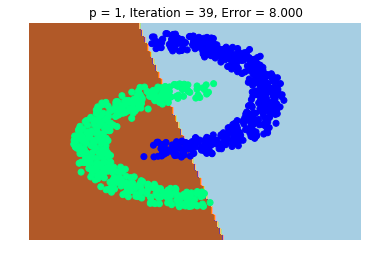

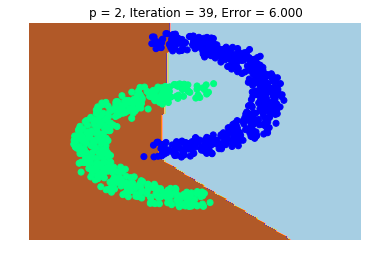

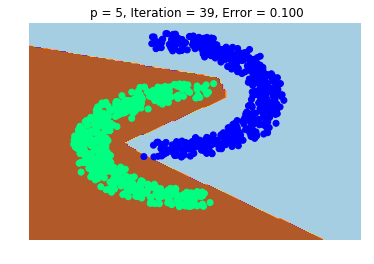

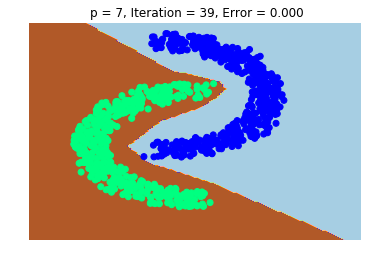

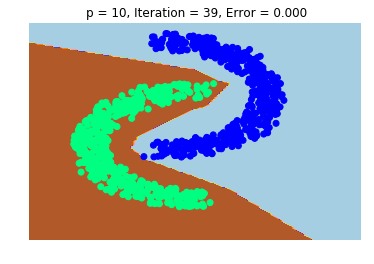

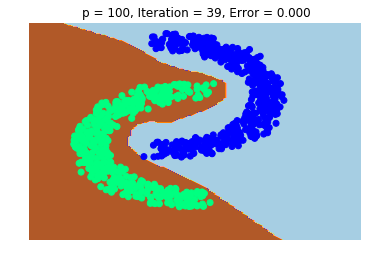

In [138]:
##########################
#                        #
#  WRITE YOUR CODE HERE  #
#                        #
##########################
nEpochs = 40
trials = 5
hvalues = [1, 2, 5, 7, 10, 100]
plot_data_h = np.zeros((2, trials, len(hvalues), nEpochs*1000))
lrate = 0.02
for j, hvalue in enumerate(hvalues):
    print('h = %d' % hvalue)
    for i in range(trials-1):
        tr_error, val_error = train_loop(Xtr, Ytr, Xval, Yval, hvalue, lrate, vis='never', nEpochs=nEpochs)
        plot_data_h[0, i, j, :] = tr_error
        plot_data_h[1, i, j, :] = val_error
    tr_error, val_error = train_loop(Xtr, Ytr, Xval, Yval, hvalue, lrate, vis='last', nEpochs=nEpochs)
    plot_data_h[0, 4, j, :] = tr_error
    plot_data_h[1, 4, j, :] = val_error

Text(0, 0.5, 'training error')

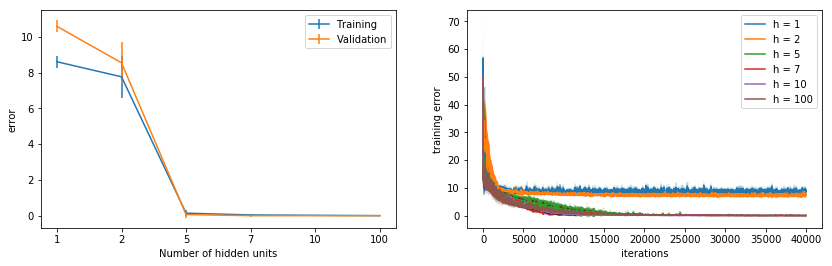

In [139]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.errorbar(np.arange(len(hvalues)), plot_data_h[0, :, :, -1].mean(axis=0), yerr=plot_data_h[0, :, :, -1].std(axis=0), label='Training')
plt.errorbar(np.arange(len(hvalues)), plot_data_h[1, :, :, -1].mean(axis=0), yerr=plot_data_h[0, :, :, -1].std(axis=0), label='Validation')
plt.xticks(np.arange(len(hvalues)), hvalues)
plt.xlabel('Number of hidden units')
plt.ylabel('error')
plt.legend()

# Plot the evolution of the training loss for each learning rate
# plt.figure()
plt.subplot(1,2,2)
for j, hvalue in enumerate(hvalues):
    x = np.arange(plot_data_h.shape[3])
    # Mean training loss over trials
    y = plot_data_h[0, :, j, :].mean(axis=0)
    # Standard deviation over trials
    ebar = plot_data_h[0, :, j, :].std(axis=0)
    # Plot
    markers, caps, bars = plt.errorbar(x, y, yerr=ebar, label='h = ' + str(hvalue))
    # Make the error bars transparent
    [bar.set_alpha(0.01) for bar in bars]
plt.legend()
plt.xlabel('iterations')
plt.ylabel('training error')

######################

We can see from the decision boundary plots that the more hidden units we have the smoother is the decision boundary, and for low values (1 and 2 ) it couldn't classify correctly all the points. 

we can see that for small values of h we are far from a zero error with a noticeable difference in performance between training and validation while for bigger values they all converge to perfect classifier.

we can see also that for small values they reach a plateau where they oscilate around it while for bigger values they converge to zero error. so we can say that for a small number of hidden units doesn't create a decision boundary complex enough to classify correctly the points.

######################

# Part 2 - Building blocks of a CNN

This part introduces typical CNN building blocks, such as ReLU units and linear filters. For a motivation for using CNNs over fully-connected neural networks, see [[Le Cun, et al, 1998]](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).


## Install PyTorch

In [144]:
# Install PyTorch (http://pytorch.org/)
from os import path
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
iscuda = False 
if accelerator == 'cu80' : 
    iscuda = True 
# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.4.1
False


## Convolution

A feed-forward neural network can be thought of as the composition of number of functions 
$$
f(\mathbf{x}) = f_L(\dots f_2(f_1(\mathbf{x};\mathbf{w}_1);\mathbf{w}_2)\dots),\mathbf{w}_{L}).
$$
Each function $f_l$ takes as input a datum $\mathbf{x}_l$ and a parameter vector $\mathbf{w}_l$ and produces as output a datum $\mathbf{x}_{l+1}$. While the type and sequence of functions is usually handcrafted, the parameters $\mathbf{w}=(\mathbf{w}_1,\dots,\mathbf{w}_L)$ are *learned from data* in order to solve a target problem, for example classifying images or sounds.

In a *convolutional neural network* data and functions have additional structure. The data $\mathbf{x}_1,\dots,\mathbf{x}_n$ are images, sounds, or more in general maps from a lattice$^1$ to one or more real numbers. In particular, since the rest of the practical will focus on computer vision applications, data will be 2D arrays of pixels. Formally, each $\mathbf{x}_i$ will be a $M \times N \times K$ real array of $M \times N$ pixels and $K$ channels per pixel. Hence the first two dimensions of the array span space, while the last one spans channels. Note that only the input $\mathbf{x}=\mathbf{x}_1$ of the network is an actual image, while the remaining data are intermediate *feature maps*.

The second property of a CNN is that the functions $f_l$ have a *convolutional structure*. This means that $f_l$ applies to the input map $\mathbf{x}_l$ an operator that is *local and translation invariant*. Examples of convolutional operators are applying a bank of linear filters to $\mathbf{x}_l$. 

In this part we will familiarise ourselves with a number of such convolutional and non-linear operators. The first one is the regular *linear convolution* by a filter bank. We will start by focusing our attention on a single function relation as follows:
$$
 f: \mathbb{R}^{M\times N\times K} \rightarrow \mathbb{R}^{M' \times N' \times K'},
 \qquad \mathbf{x} \mapsto \mathbf{y}.
$$

$^1$A two-dimensional *lattice* is a discrete grid embedded in $R^2$, similar for example to a checkerboard.

C:\Users\Amine\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


(384, 512, 3)


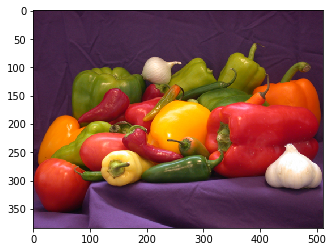

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import torch
import torchvision

# Download an example image
!wget -q http://www.di.ens.fr/willow/teaching/recvis/assignment3/images/peppers.png
# Read the image 
x = scipy.misc.imread('peppers.png')/255.0
# Print the size of x. Third dimension (=3) corresponds to the R, G, B channels
print(x.shape)
# Visualize the input x
plt.imshow(x)
# Convert to torch tensor
x = torch.from_numpy(x).permute(2, 0, 1).float()
# Prepare it as a batch
x = x.unsqueeze(0)

This should display an image of bell peppers.

Next, we create a convolutional layer with a bank of 10 filters of dimension $5 \times 5 \times 3$ whose coefficients are initialized randomly. This uses the [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) module from PyTorch:

In [43]:
# Create a convolutional layer and a random bank of linear filters
conv = torch.nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=0, bias=False)
print(conv.weight.size())

torch.Size([10, 3, 5, 5])


**Remark:** You might have noticed that the `bias` argument to the `torch.nn.Conv2d` function is the empty matrix `false`. It can be otherwise used to pass a vector of bias terms to add to the output of each filter.

Note that `conv.weight` has four dimensions, packing 10 filters. Note also that each filter is not flat, but rather a volume containing three slices. The next step is applying the filter to the image.

In [44]:
# Apply the convolution operator
y = conv(x)
# Observe the input/output sizes
print(x.size())
print(y.size())

torch.Size([1, 3, 384, 512])
torch.Size([1, 10, 380, 508])


The variable `y` contains the output of the convolution. Note that the filters are three-dimensional. This is because they operate on a tensor $\mathbf{x}$ with $K$ channels. Furthermore, there are $K'$ such filters, generating a $K'$ dimensional map $\mathbf{y}$.

We can now visualise the output `y` of the convolution. In order to do this, use the `torchvision.utils.make_grid` function to display an image for each feature channel in `y`:

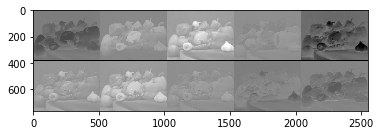

In [45]:
# Visualize the output y
def vis_features(y):
    # Organize it into 10 grayscale images
    out = y.permute(1, 0, 2, 3)
    # Scale between [0, 1]
    out = (out - out.min().expand(out.size())) / (out.max() - out.min()).expand(out.size())
    # Create a grid of images
    out = torchvision.utils.make_grid(out, nrow=5)
    # Convert to numpy image
    out = np.transpose(out.detach().numpy(), (1, 2, 0))
    # Show
    plt.imshow(out)
    # Remove grid
    plt.gca().grid(False)

vis_features(y)

So far filters preserve the resolution of the input feature map. However, it is often useful to *downsample the output*. This can be obtained by using the `stride` option in `torch.nn.Conv2d`:

torch.Size([1, 3, 384, 512])
torch.Size([1, 10, 24, 32])


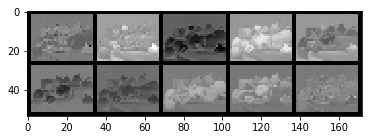

In [46]:
# Try again, downsampling the output
conv_ds = torch.nn.Conv2d(3, 10, kernel_size=5, stride=16, padding=0, bias=False)
y_ds = conv_ds(x)
print(x.size())
print(y_ds.size())
vis_features(y_ds)

Applying a filter to an image or feature map interacts with the boundaries, making the output map smaller by an amount proportional to the size of the filters. If this is undesirable, then the input array can be padded with zeros by using the `pad` option:

torch.Size([1, 3, 384, 512])
torch.Size([1, 10, 384, 512])


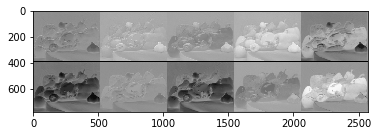

In [47]:
# Try padding
conv_pad = torch.nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2, bias=False)
y_pad = conv_pad(x)
print(x.size())
print(y_pad.size())
vis_features(y_pad)

In order to consolidate what has been learned so far, we will now design a filter by hand:


torch.Size([1, 3, 384, 512])
torch.Size([1, 1, 384, 512])


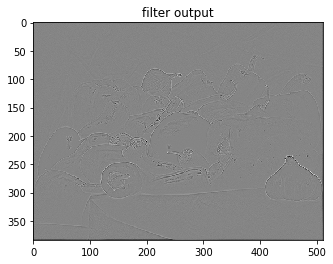

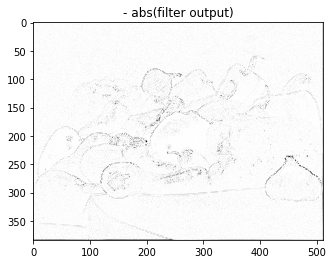

In [48]:
w = torch.FloatTensor([[0,  1, 0 ],
                      [1, -4, 1 ],
                      [0,  1, 0 ]]) 
w = w.repeat(3, 1).reshape(1, 3, 3, 3)
conv_lap = torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1, bias=False)
conv_lap.weight = torch.nn.Parameter(w) 
y_lap = conv_lap(x)
print(x.size())
print(y_lap.size())

plt.figure()
vis_features(y_lap)
plt.title('filter output')

plt.figure()
vis_features(-torch.abs(y_lap))
plt.title('- abs(filter output)') ;


### :: TASK 2.1 ::
* i. What filter have we implemented?
* ii. How are the RGB colour channels processed by this filter?
* iii. What image structure are detected?

######################

This filter compares if pixels in some area are different,(left,right,up,down compared to the middle pixel). if they are it gives a value of 0 if not it computes the difference, it returns in the end all edges. 

all RGB channels are processed with the same filter and the values are summed. 

we detect the contours of all objects in the picture.
######################


## Non-linear activation functions

The simplest non-linearity is obtained by following a linear filter by a *non-linear activation function*, applied identically to each component (i.e. point-wise) of a feature map. The simplest such function is the *Rectified Linear Unit (ReLU)*
$$
  y_{ijk} = \max\{0, x_{ijk}\}.
$$
This function is implemented by [`torch.nn.ReLU()`](https://pytorch.org/docs/stable/nn.html#torch.nn.ReLU). Run the code below and understand what the filter $\mathbf{w}$ is doing.


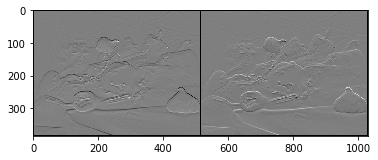

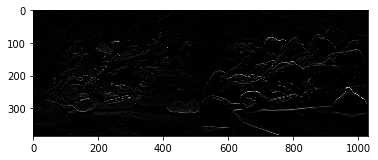

In [49]:
w = torch.FloatTensor([[1], [0], [-1]]).repeat(1, 3, 1, 1)
w = torch.cat((w, -w), 0)

conv = torch.nn.Conv2d(3, 2, kernel_size=(3, 1), stride=1, padding=0, bias=False)
conv.weight = torch.nn.Parameter(w)
relu = torch.nn.ReLU()

y = conv(x)
z = relu(y)

plt.figure()
vis_features(y)
plt.figure()
vis_features(z)

## Pooling
There are several other important operators in a CNN. One of them is *pooling*.  A pooling operator operates on individual feature channels, coalescing nearby feature values into one by the application of a suitable operator. Common choices include max-pooling (using the max operator) or sum-pooling (using summation). For example, *max-pooling* is defined as:
$$
   y_{ijk} = \max \{ y_{i'j'k} : i \leq i' < i+p, j \leq j' < j + p \}
$$
Max-pooling is implemented by [`torch.nn.MaxPool2d()`](https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d).

### :: TASK 2.2 ::

Run the code below to try max-pooling. Look at the resulting image. Can you interpret the result?

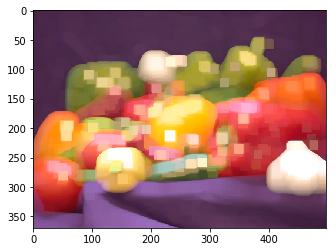

In [55]:
mp = torch.nn.MaxPool2d(15, stride=1)
y = mp(x)
plt.imshow(y.squeeze().permute(1, 2, 0).numpy())
plt.gca().grid(False)


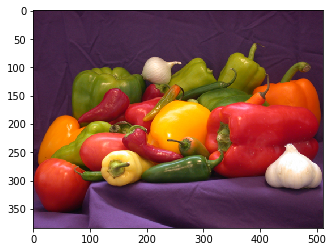

In [56]:
plt.imshow(x.squeeze().permute(1, 2, 0).numpy())

######################

it gives more importance to big values for exemple when there is some reflection of the light on the peppers with maxpooling it becomes a big white because we take stride=1 so those values are taken into account multiple times. 

######################

# Part 3 - Training a CNN

This part is an introduction to using PyTorch for training simple neural net models. CIFAR-10 dataset will be used.

## Imports

In [57]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

## Parameters

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. 
Unless otherwise specified, use the default values throughout this assignment. 

In [58]:
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01         # learning rate

## Warmup





It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes
(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

In [59]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the dataset from the internet
dataset = 'cifar10'
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
testset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Files already downloaded and verified


### :: TASK 3.1 ::

Use `matplotlib` and ipython notebook's visualization capabilities to display some of these images. Display 5 images from the dataset together with their category label. [See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

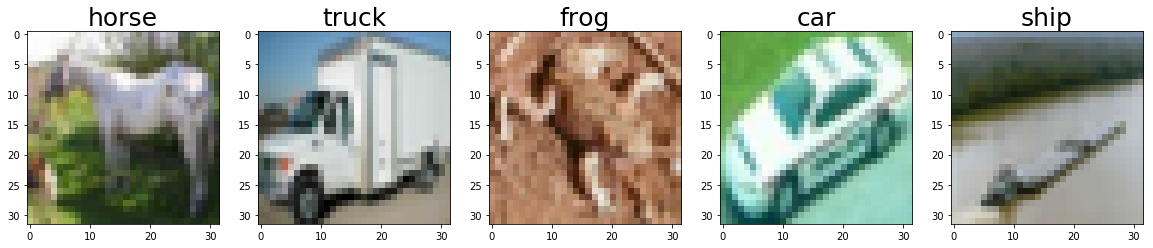

In [145]:
##########################
#                        #
#  WRITE YOUR CODE HERE  #
#                        #
##########################
import matplotlib.pyplot as plt
import numpy as np
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# show images
n_col = 5
plt.figure(figsize=(20,5))
for i, image in enumerate(images[:n_col]):
  plt.subplot(1, n_col, i+1 )
  plt.imshow(imshow(image))
  plt.title(classes[labels[i]],fontsize=25)
  plt.gca().grid(False)


## Training a Convolutional Network on CIFAR-10




Start by running the provided training code below. By default it will train on CIFAR-10 for 10 epochs (passes through the training data) with a single layer network. The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`. Note the decrease in training loss and corresponding decrease in validation errors.

In [70]:
def train(epoch, network):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        if iscuda : 
            data , target = data.cuda() , target.cuda()
            network = network.cuda()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(network):
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if iscuda : 
            data , target = data.cuda() , target.cuda()
            network = network.cuda()
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [71]:
# Single layer network architecture

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
        self.num_inputs = num_inputs
        
    def forward(self, input):
        input = input.view(-1, self.num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

In [72]:
# Train
network = Net(3072, 10)
optimizer = optim.SGD(network.parameters(), lr=lr)
for epoch in range(1, 11):
    train(epoch, network)
    test(network)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.284492
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.914098
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.815706
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.879540
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.979751
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.843467
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.856027
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.933287


C:\Users\Amine\Anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.7802, Accuracy: 19593/50000 (39%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.726869
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.732326
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.754232
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.720448
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.762834
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.801572
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.546630
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.703583

Test set: Average loss: 1.7326, Accuracy: 20442/50000 (40%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.751793
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.661151
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.605075
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.750581
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.697586
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.707311
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.606124
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.832745

Test set: Average loss: 1.7074, Accuracy: 20960/50000 (41%)

Train Epoch: 4 [0/50000 (0

### :: TASK 3.2 ::

Add code to create a convolutional network architecture as below.

  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

In [78]:
import torch.nn as nn
class ConvNet(nn.Module):
    ##########################
    #                        #
    #  WRITE YOUR CODE HERE  #
    #                        #
    ##########################
    def __init__(self, num_outputs):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 128, 5)
        self.fc1 = nn.Linear(128 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, num_outputs)

    def forward(self, x):
        x = self.pool(torch.tanh(self.conv1(x)))
        x = self.pool(torch.tanh(self.conv2(x)))
        x = x.view(-1, 128 * 5 * 5)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

### :: TASK 3.3 ::

Some of the functions in a CNN must be non-linear. Why?





######################

If we don't add any linearity, no matter how much hiddend layers we use the network in the end will be equivalent to linear regression, the non linearity makes it possible for the network to learn non linear, more complex functions.
######################

### :: TASK 3.4 ::
Train the CNN for 20 epochs on the CIFAR-10 training set.



In [79]:
# Train
network=ConvNet(10)
optimizer = optim.SGD(network.parameters(), lr=lr)
for epoch in range(1, 21):
    train(epoch, network)
    test(network)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.284195
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.088313
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.940318
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.894400
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.686043
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.985073
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.728066
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.980810


C:\Users\Amine\Anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.8109, Accuracy: 18691/50000 (37%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.668095
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.665619
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.763582
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.790762
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.805431
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.683412
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.608494
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.572271

Test set: Average loss: 1.6072, Accuracy: 21385/50000 (42%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.592296
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.593976
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.468197
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.581278
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.546855
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.536393
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.660235
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.341989

Test set: Average loss: 1.4567, Accuracy: 23949/50000 (47%)

Train Epoch: 4 [0/50000 (0

### :: TASK 3.5 ::
Plot the first convolutional layer weights as images after the last epoch. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )


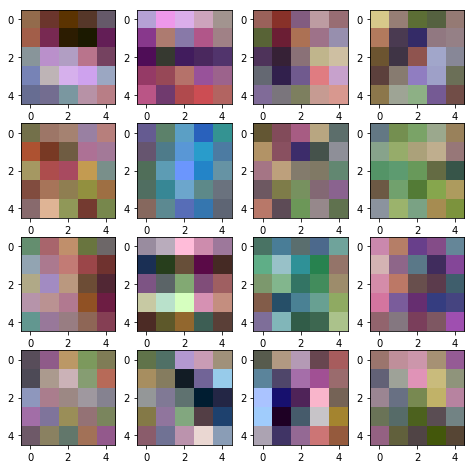

In [152]:
##########################
#                        #
#  WRITE YOUR CODE HERE  #
#                        #
##########################
W = list(network.parameters())[0]

minimum = np.min(W.cpu().detach().numpy(),axis=(0,2,3),keepdims=True)[0]
maximum = np.max(W.cpu().detach().numpy(),axis=(0,2,3),keepdims=True)[0]

fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    
    plt.imshow( ((W[i-1].cpu().detach().numpy() - minimum)/(maximum-minimum)).T ,cmap=)
#     plt.title('weights of filter {}'.format(i))
    plt.gca().grid(False)
plt.show()

### :: TASK 3.6 :: 

What is the dimensionality of the weights at each layer? How many parameters are there in total in this CNN architecture?

######################


- Conv 1 : size  = **(16, 3, 5, 5)** , number of parameters in this layer : **16x3x5x5** =  **1200**
 - Bias Conv 1  size  = **(16)** , number of parameters in this layer : **16**
- Conv 2 : size  = **(128, 16, 5, 5)** , number of parameters in this layer : **128x16x5x5** =  **51200**
 - Bias Conv 2 : size  = **(128)** , number of parameters in this layer : **128**  
- fc1 : size  = **(64,3200)** , number of parameters in this layer : **64x3200**  =  **204800**
 - fc1 bias size  = **(64)** , number of parameters in this layer **64 **   
- fc2 : size  = **(10, 64)** , number of parameters in this layer : **10x64** = **640**  
 - fc2 bias : size  = **(10)** , number of parameters in this layer **10**   
 
 
 The total number of parameters in the CNN is then :   **258 058**
######################



## Useful resources

  - [PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py)
  - [MNIST example](https://github.com/pytorch/examples/tree/master/mnist)

## AUTHORSHIP STATEMENT

I declare that the preceding work was the sole result of my own effort and that I have not used any code or results from third-parties.

FILL IN YOUR NAME HERE